In [44]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../smc')
sys.path.append('../third_party')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import numpy as np   
import pandas as pd
import scipy.stats as stats
import sys
from tqdm import tqdm

from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *
from missingness_estimation import *

In [46]:
r = 2
scale = 5
seed = 1

# Fixed data parameters
max_test_queries = 100            
max_calib_queries = 2000
matrix_generation_seed = 2024    # Data matrix is fixed 

n1 = n2 = 400

model = "RFM"
solver = "pmf"
prop_obs = 0.3


# Other parameters
verbose = True
allow_inf = False
alpha = 0.1

k_list = [5]
repetition = 1

In [47]:
#################
# Generate Data #
#################
if model == "RFM":
    mm = RandomFactorizationModel(n1 ,n2, 8)
elif model == "ROM":
    mm = RandomOrthogonalModel(n1 ,n2, 8)
else:
    mm = RandomFactorizationModel(n1 ,n2, 8)

if verbose:
    print('Fixing the ground truth matrix generated from the {} model.\n'.format(model))
    sys.stdout.flush()

U, V, M = mm.sample_noiseless(matrix_generation_seed)

Fixing the ground truth matrix generated from the RFM model.



In [48]:
n1, n2 = M.shape
bm = SamplingBias(n1,n2)
w_obs = bm.inc_weights(scale = scale)

In [49]:
#w_obs_log = bm.inc_weights(scale = scale, logistic=True)

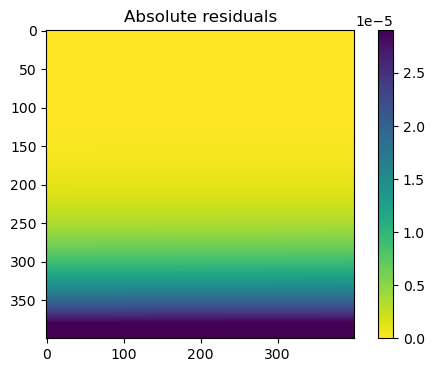

In [50]:
error_heatmap(w_obs, np.zeros_like(M), np.ones_like(M))

In [51]:
#####################
# Define Experiment #
#####################
def run_single_experiment(M_true, k, alpha, prop_obs, max_test_queries, max_calib_queries,
                          r,scale, random_state=0):
    res = pd.DataFrame({})


    #--------Observation bias-------#
    #-------------------------------#
    n1, n2 = M_true.shape
    bm = SamplingBias(n1,n2)
    w_obs = bm.inc_weights(scale = scale,logistic=True)

    #-------Generate masks----------#
    #-------------------------------#
    sampler = QuerySampling(n1,n2)
    mask_obs, mask_test = sampler.sample_submask(sub_size=prop_obs, w=w_obs, random_state=random_state)
    n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)

    print(f"Estimating missingness with guessed rank {r}...")
    w_obs_est = estimate_P(mask_obs, 1, r=r, const=5)
    pdb.set_trace()
    print("Done estimating!\n")
    sys.stdout.flush()
    
    #------Sample test queries------#
    #-------------------------------#
    n_test_queries = min(int(0.99 * np.sum(np.sum(mask_test, axis=1) // k)), max_test_queries)
    _, idxs_test, _ = sampler.sample_train_calib(mask_test, k, calib_size=n_test_queries, random_state=random_state)  
    if verbose:
        print("Training size:{}, calib size: {}, test size: {}\n".format(np.sum(mask_obs)-n_calib_queries*k, n_calib_queries, n_test_queries))
        sys.stdout.flush()


    #------Split train calib--------#
    #-------------------------------#
    mask_train, idxs_calib, _ = sampler.sample_train_calib(mask_obs, k, 
                                calib_size=n_calib_queries, random_state=random_state)

    #--------Model Training---------#
    #-------------------------------#
    print("Running matrix completion algorithm on the splitted training set...")
    sys.stdout.flush()
    if solver == "pmf":
        Mhat, _, _ = pmf_solve(M, mask_train, k=r, max_iteration=50, verbose=verbose, random_state=random_state)
    elif solver == "svt":
        Mhat = svt_solve(M, mask_train, verbose = verbose, random_state = random_state)
    print("Done training!\n")
    sys.stdout.flush()


    #------Compute intervals--------# 
    #-------------------------------#

    # Evaluate the CI and quantile inflation weights using oracle obs sampling weights
    ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=w_obs)
    df = ci_method.get_CI(idxs_test, alpha, allow_inf=allow_inf, store_weights=True)
    lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
    res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="conformal")])

    # Evaluate the CI and quantile inflation weights using estimated obs sampling weights
    ci_est = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=w_obs_est)
    df = ci_est.get_CI(idxs_test, alpha, allow_inf=allow_inf, store_weights=True)
    lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf
    res = pd.concat([res, evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="est")])

    # Evaluate the estimation gap
    weights_list = ci_method.weights_list
    est_weights_list = ci_est.weights_list
    est_gaps =[0.5*np.sum(np.abs(weights_list[i]-est_weights_list[i])) for i in range(len(weights_list))]
    avg_gap = np.mean(est_gaps)


    res['k'] = k 
    res['avg_gap'] = avg_gap   
    res['Calib_queries'] = n_calib_queries
    res['Train_entries'] = np.sum(mask_train)
    res['Test_queries'] = n_test_queries
    res['random_state'] = random_state
    return res

In [ ]:
#####################
#  Run Experiments  #
#####################
results = pd.DataFrame({})

for i in tqdm(range(1, repetition+1), desc="Repetitions", leave=True, position=0):
    random_state = repetition * (seed-1) + i
    
    for k in tqdm(k_list, desc="k", leave=True, position=0):

        res = run_single_experiment(M, k, alpha, prop_obs, max_test_queries, max_calib_queries,
                            r, scale=scale, random_state=random_state)
        
        results = pd.concat([results, res])

k:   0%|                                                                                         | 0/1 [00:00<?, ?it/s]

Estimating missingness with guessed rank 2...
iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
Function value changing by less than progTol
> c:\users\liang\appdata\local\temp\ipykernel_31236\856256955.py(24)run_single_experiment()



ipdb>  print(w_obs)


[[0.07585928 0.07586147 0.07586366 ... 0.0767336  0.07673581 0.07673803]
 [0.07674024 0.07674246 0.07674467 ... 0.07762387 0.07762611 0.07762834]
 [0.07763058 0.07763282 0.07763506 ... 0.07852359 0.07852585 0.07852811]
 ...
 [0.92147189 0.92147415 0.92147641 ... 0.92236494 0.92236718 0.92236942]
 [0.92237166 0.92237389 0.92237613 ... 0.92325533 0.92325754 0.92325976]
 [0.92326197 0.92326419 0.9232664  ... 0.92413634 0.92413853 0.92414072]]


ipdb>  print(w_obs_est)


[[0.09318838 0.08483784 0.09453608 ... 0.09619374 0.08048324 0.08427115]
 [0.08402829 0.07626421 0.08512492 ... 0.08780046 0.07224793 0.07604174]
 [0.07022388 0.06434535 0.07005677 ... 0.07943208 0.06141764 0.06613211]
 ...
 [0.47281352 0.47619566 0.46893246 ... 0.49175771 0.47858797 0.48356978]
 [0.50711181 0.50409239 0.51001329 ... 0.49359405 0.50204269 0.49871317]
 [0.5296968  0.52418964 0.53553273 ... 0.50170952 0.52036512 0.51319614]]


In [ ]:
results

In [63]:
600*600/(400*400)

2.25